<a href="https://colab.research.google.com/github/saugabriele/NetSec_lab/blob/main/NetSec_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount("/content/drive")

file_path = "/content/drive/My Drive/Train_Test_Network.csv"
traffic_df = pd.read_csv(file_path)
traffic_df = traffic_df.sort_index(axis=1)  # Sort columns by alphabetical order

analysis_df = traffic_df[['conn_state', 'proto', 'type', 'dst_pkts',
                          'src_pkts', 'dst_bytes', 'src_bytes']]

Mounted at /content/drive


In [ ]:
category_mapping = {
    'backdoor': 'Other',
    'ddos': 'DoS or DDoS',
    'dos': 'DoS or DDoS',
    'injection': 'Other',
    'mitm': 'Other',
    'normal': 'Other',
    'password': 'Other',
    'ransomware': 'Other',
    'scanning': 'Other',
    'xss': 'Other'
}

analysis_df.loc[:, 'type'] = analysis_df['type'].replace(category_mapping)

type_proto_counts = analysis_df.groupby('type')['proto'].value_counts().unstack(fill_value=0)
print(type_proto_counts)

# SHUFFLING
clean_df = analysis_df.sample(frac=1).reset_index(drop=True)

proto        icmp     tcp     udp
type                             
DoS or DDoS     0   33250    6750
Other        5880  248826  166337


#TCP Flooding

In [ ]:
import matplotlib.pyplot as plt

def plot_conn_state_percentages(subset_numbers, percent_sus, percent_not_sus, title):
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(subset_numbers, percent_not_sus, label='Not Suspicious', marker='o')
    plt.plot(subset_numbers, percent_sus, label='Suspicious', marker='o')

    plt.xlabel('Subset Number')
    plt.title(title)
    plt.legend()
    plt.ylim(0, max(max(percent_not_sus), max(percent_sus))+2)  # Set y-axis limits between 0 and 1
    plt.grid(True)
    plt.show()

In [ ]:
DoS_conn_state_mapping = {
    'S0': 'Suspicious',
    'SF': 'Not Suspicious',
    'OTH': 'Not Suspicious',
    'RSTR': 'Suspicious',
    'SH': 'Suspicious',
    'SHR': 'Suspicious',
    'REJ': 'Suspicious',
    'S3': 'Not Suspicious',
    'S1': 'Not Suspicious',
    'RSTO': 'Suspicious',
    'RSTRH': 'Not Suspicious',
    'S2': 'Not Suspicious',
    'RSTOS0': 'Suspicious'
}

clean_df.loc[clean_df['proto']=='tcp', 'conn_state'] = clean_df[clean_df['proto']=='tcp']['conn_state'].replace(DoS_conn_state_mapping)

subset_size = 1000
subsets = [clean_df.iloc[i:i + subset_size] for i in range(0, len(clean_df), subset_size)]

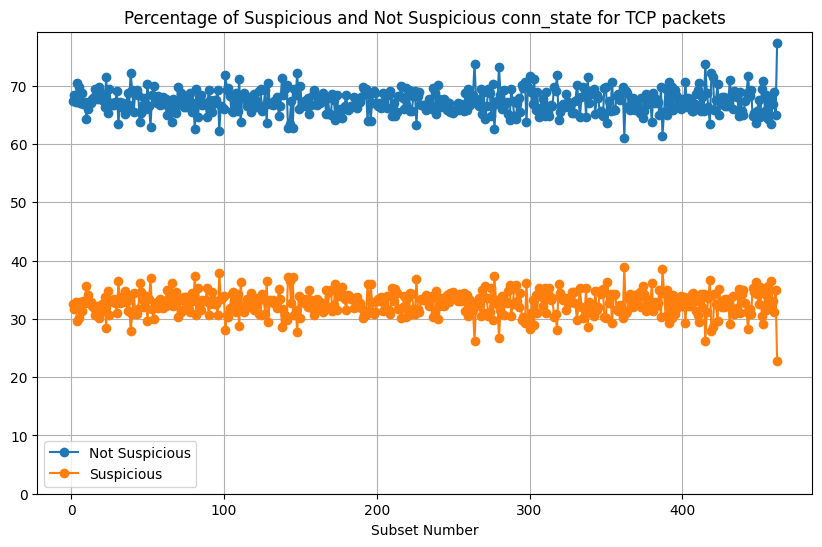

Threshold: 50.0000


In [ ]:
# Initialize lists to store results
percent_conn_state_not_sus = []
percent_conn_state_sus = []

# Calculate the percentage of each suspicious connection states in each subset
subset_numbers = []
for i, subset in enumerate(subsets, start=1):
    total_conn_state_not_sus = subset[subset['conn_state'] == 'Not Suspicious']['conn_state'].value_counts(normalize=False)
    total_conn_state_sus = subset[subset['conn_state'] == 'Suspicious']['conn_state'].value_counts(normalize=False)
    total_conn_state_not_sus = total_conn_state_not_sus.get('Not Suspicious', 0)
    total_conn_state_sus = total_conn_state_sus.get('Suspicious', 0)

    total_number_of_TCP = total_conn_state_not_sus + total_conn_state_sus

    # Append the results to the lists
    subset_numbers.append(i)
    percent_conn_state_not_sus.append(total_conn_state_not_sus * 100 / total_number_of_TCP)
    percent_conn_state_sus.append(total_conn_state_sus * 100 / total_number_of_TCP)

title_plot = "Percentage of Suspicious and Not Suspicious conn_state for TCP packets"
plot_conn_state_percentages(subset_numbers, percent_conn_state_sus,
                            percent_conn_state_not_sus, title_plot)

# Calculate the thresholds
threshold_tcp = (np.average(percent_conn_state_not_sus) + np.average(percent_conn_state_sus))/2
print(f'Threshold: {threshold_tcp:.4f}')

#UDP flooding

In [ ]:
def plot_udp_features(subset_numbers, features, titles):
    # Plot the results
    fig, axs = plt.subplots(4, 1, figsize=(10, 30))
    for i in range(4):
      axs[i].plot(subset_numbers, features[(i*2)+1], label='Others', marker='o')
      axs[i].plot(subset_numbers, features[(i*2)], label='Dos or DDoS', marker='o')

      axs[i].set_xlabel('Subset Number')
      axs[i].set_title(titles[i])
      axs[i].legend()
      axs[i].set_ylim(0, max(max(features[(i*2)]), max(features[(i*2)+1]))+2)  # Set y-axis limits between 0 and 1
      axs[i].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
clean_df = analysis_df.sample(frac=1).reset_index(drop=True)

clean_df = clean_df.loc[clean_df['proto']=='udp']
subset_size = 1000
subsets = [clean_df.iloc[i:i + subset_size] for i in range(0, len(clean_df), subset_size)]

In [ ]:
mean_dst_pkts_DoS = []
mean_dst_pkts_not_DoS = []
mean_src_pkts_DoS = []
mean_src_pkts_not_DoS = []
mean_dst_bytes_DoS = []
mean_dst_bytes_not_DoS = []
mean_src_bytes_DoS = []
mean_src_bytes_not_DoS = []


subset_numbers = []

for i, subset in enumerate(subsets, start=1):
    DoS_or_DDoS = subset[subset['type'] == 'DoS or DDoS']
    Others = subset[subset['type'] == 'Other']

    # Append the results to the lists
    subset_numbers.append(i)
    mean_dst_pkts_DoS.append(DoS_or_DDoS['dst_pkts'].astype(int).mean())
    mean_dst_pkts_not_DoS.append(Others['dst_pkts'].astype(int).mean())
    mean_src_pkts_DoS.append(DoS_or_DDoS['src_pkts'].astype(int).mean())
    mean_src_pkts_not_DoS.append(Others['src_pkts'].astype(int).mean())
    mean_dst_bytes_DoS.append(DoS_or_DDoS['dst_bytes'].astype(int).mean())
    mean_dst_bytes_not_DoS.append(Others['dst_bytes'].astype(int).mean())
    mean_src_bytes_DoS.append(DoS_or_DDoS['src_bytes'].astype(int).mean())
    mean_src_bytes_not_DoS.append(Others['src_bytes'].astype(int).mean())


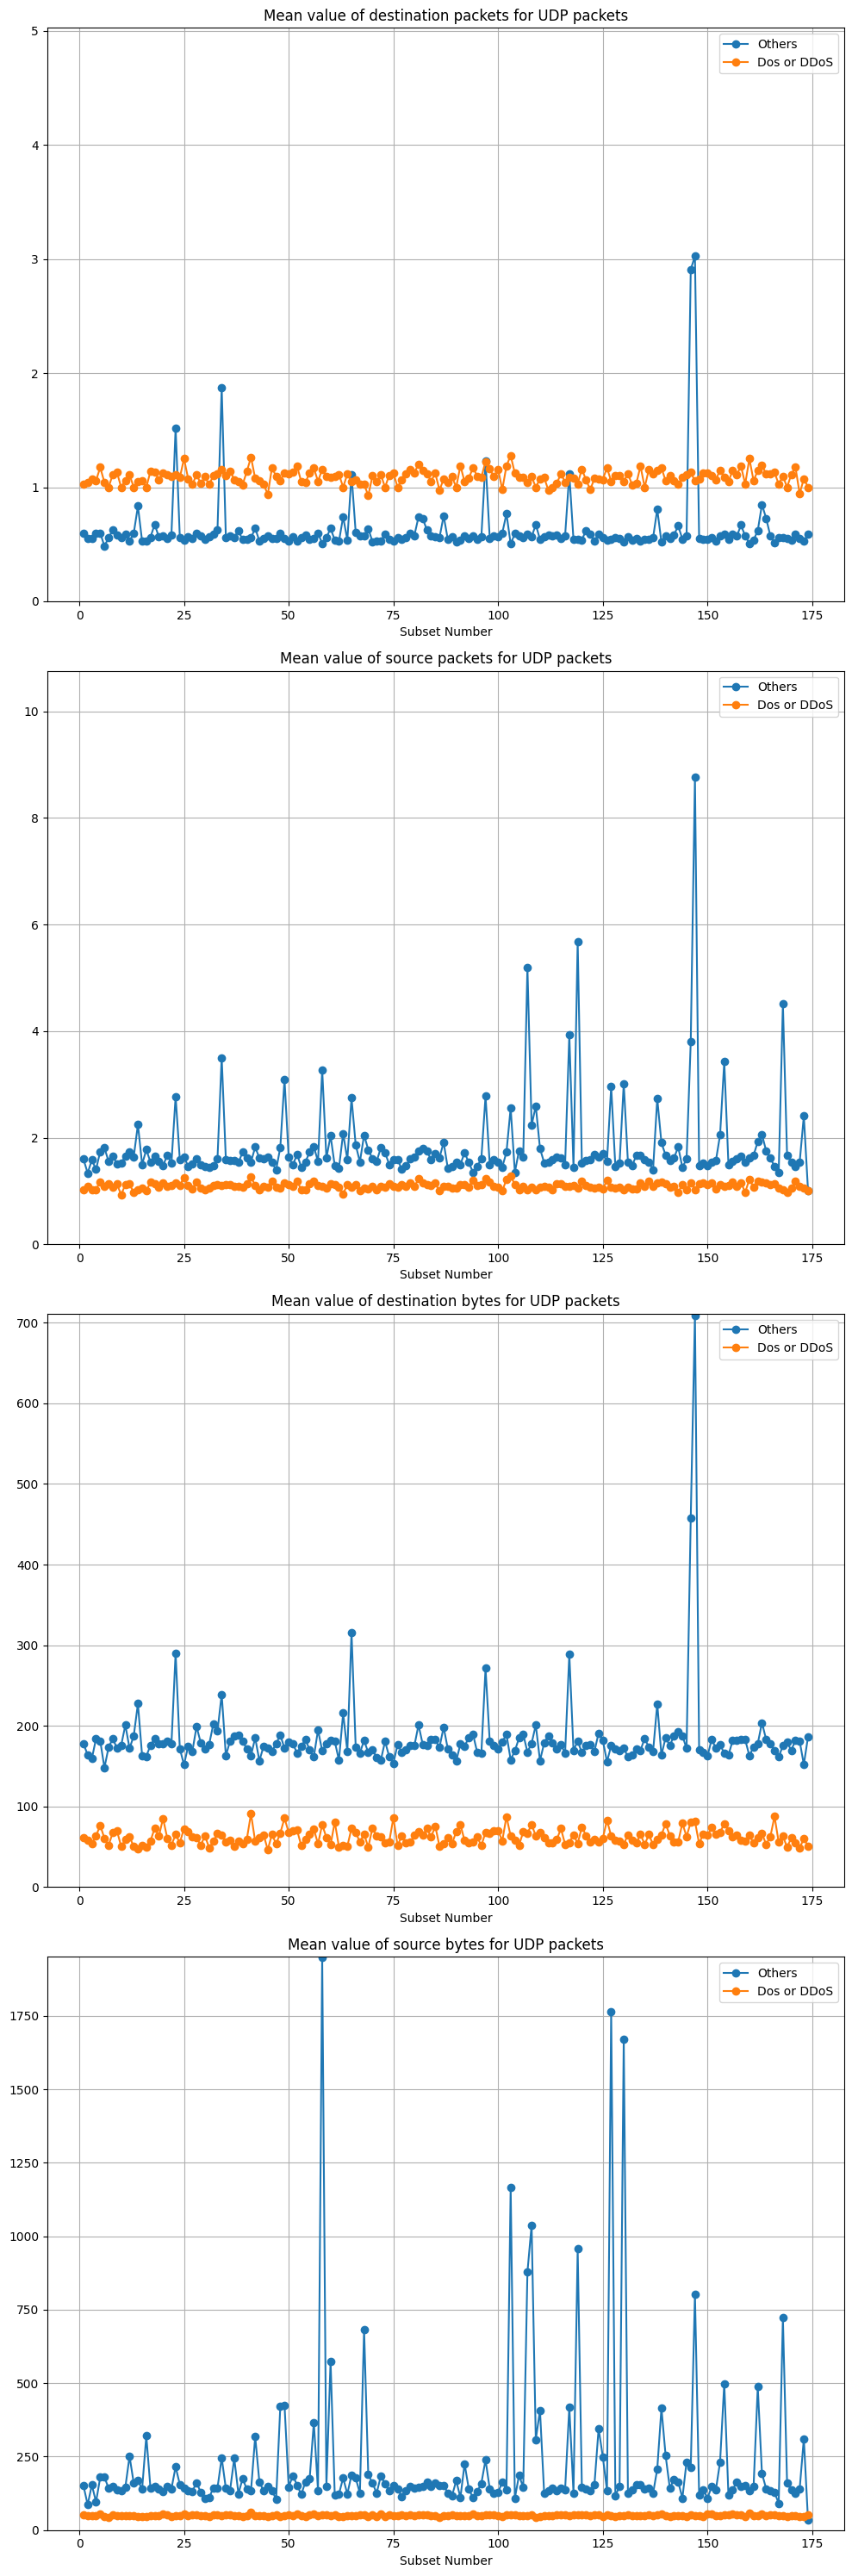

In [ ]:
plot_titles = ["Mean value of destination packets for UDP packets",
               "Mean value of source packets for UDP packets",
               "Mean value of destination bytes for UDP packets",
               "Mean value of source bytes for UDP packets"]

mean_values = [mean_dst_pkts_DoS, mean_dst_pkts_not_DoS,
               mean_src_pkts_DoS, mean_src_pkts_not_DoS,
               mean_dst_bytes_DoS, mean_dst_bytes_not_DoS,
               mean_src_bytes_DoS, mean_src_bytes_not_DoS]

plot_udp_features(subset_numbers, mean_values, plot_titles)

In [ ]:
# Calculate the thresholds
threshold_dst_pkts = (np.average(mean_values[0]) + np.average(mean_values[1]))/2
threshold_src_pkts = (np.average(mean_values[2]) + np.average(mean_values[3]))/2
threshold_dst_bytes = (np.average(mean_values[4]) + np.average(mean_values[5]))/2
threshold_src_bytes = (np.average(mean_values[6]) + np.average(mean_values[7]))/2

print(f'Threshold mean destination packets: {threshold_dst_pkts:.4f}')
print(f'Threshold mean source packets: {threshold_src_pkts:.4f}')
print(f'Threshold mean destination bytes: {threshold_dst_bytes:.4f}')
print(f'Threshold mean source bytes: {threshold_src_bytes:.4f}')

Threshold mean destination packets: 0.8570
Threshold mean source packets: 1.4649
Threshold mean destination bytes: 123.0763
Threshold mean source bytes: 138.6064


In [ ]:
percent_dst_pkts_higher = []
percent_src_pkts_lower =[]
percent_dst_bytes_lower = []
percent_src_bytes_lower = []

subset_numbers = []
total_number_of_UDP = len(clean_df[clean_df['proto'] == 'udp'])

for i, subset in enumerate(subsets, start=1):
  percent_dst_pkts_higher.append(len(subset[subset['dst_pkts'] > threshold_dst_pkts]) / len(subset))
  percent_src_pkts_lower.append(len(subset[subset['src_pkts'] < threshold_src_pkts]) / len(subset))
  percent_dst_bytes_lower.append(len(subset[subset['dst_bytes'] < threshold_dst_bytes]) / len(subset))
  percent_src_bytes_lower.append(len(subset[subset['src_pkts'] < threshold_src_bytes]) / len(subset))

thresholds_udp = []
thresholds_udp.append(np.mean(percent_dst_pkts_higher))
thresholds_udp.append(np.mean(percent_src_pkts_lower))
thresholds_udp.append(np.mean(percent_dst_bytes_lower))
thresholds_udp.append(np.mean(percent_src_bytes_lower))

print(f'Percentage of packets with higher dst_pkts than threshold mean destination packets: {thresholds_udp[0]:.4f}')
print(f'Percentage of packets with lower src_pkts than threshold mean source packets: {thresholds_udp[1]:.4f}')
print(f'Percentage of packets with lower dst_bytes than threshold mean destination bytes: {thresholds_udp[2]:.4f}')
print(f'Percentage of packets with lower src_bytes than threshold mean source bytes: {thresholds_udp[3]:.4f}')

Percentage of packets with higher dst_pkts than threshold mean destination packets: 0.4693
Percentage of packets with lower src_pkts than threshold mean source packets: 0.7874
Percentage of packets with lower dst_bytes than threshold mean destination bytes: 0.6765
Percentage of packets with lower src_bytes than threshold mean source bytes: 0.9997


In [ ]:
actual_label = []

print("What dataset you want to use to validate NTC? [Other, DoS or DDoS]")
ds_choice = input()
clean_df = analysis_df.sample(frac=1).reset_index(drop=True)

if ds_choice == 'Other':
    ds_validation = clean_df.loc[clean_df['type'] == 'Other']
    for i in range(0, int(len(ds_validation) / subset_size)):
        actual_label.append(0)
elif ds_choice == 'DoS or DDoS':
    ds_validation = clean_df.loc[clean_df['type'] == 'DoS or DDoS']
    for i in range(0, int(len(ds_validation) / subset_size)):
        actual_label.append(1)
else:  # As default option use Benevolent
    ds_validation = clean_df.loc[clean_df['type'] == 'Other']
    for i in range(0, int(len(ds_validation) / subset_size)):
        actual_label.append(0)
    print("Error")

What dataset you want to use to validate NTC? [Other, DoS or DDoS]
Other


In [ ]:
def NTC(dataset, threshold_TCP, thresholds_UDP, subset_size):
    # Replace values in "type" column
    category_mapping = {
      'S0': 'Suspicious',
      'SF': 'Not Suspicious',
      'OTH': 'Not Suspicious',
      'RSTR': 'Suspicious',
      'SH': 'Suspicious',
      'SHR': 'Suspicious',
      'REJ': 'Suspicious',
      'S3': 'Not Suspicious',
      'S1': 'Not Suspicious',
      'RSTO': 'Suspicious',
      'RSTRH': 'Not Suspicious',
      'S2': 'Not Suspicious',
      'RSTOS0': 'Suspicious'
    }

    tcp_mask = dataset['proto'] == 'tcp'
    # Replace the conn_state of TCP packets using the mask
    dataset.loc[tcp_mask, 'conn_state'] = dataset.loc[tcp_mask, 'conn_state'].replace(category_mapping)


    subsets = [dataset.iloc[i:i + subset_size] for i in range(0, len(dataset), subset_size)]

    # Calculate the percentage of TCP in "proto" for each class in each subset
    predicted_label = []
    classification = 0

    for i, subset in enumerate(subsets, start=1):
      total_conn_state_not_sus = subset[subset['conn_state'] == 'Not Suspicious']['conn_state'].value_counts(normalize=False)
      total_conn_state_sus = subset[subset['conn_state'] == 'Suspicious']['conn_state'].value_counts(normalize=False)
      total_conn_state_not_sus = total_conn_state_not_sus.get('Not Suspicious', 0)
      total_conn_state_sus = total_conn_state_sus.get('Suspicious', 0)

      total_number_of_TCP = total_conn_state_not_sus + total_conn_state_sus
      total_number_of_UDP = len(dataset[dataset['proto'] == 'udp'])
      percent_dst_pkts_higher = len(dataset[(dataset['proto'] == 'udp') & (dataset['dst_pkts'] > thresholds_UDP[0])]) / total_number_of_UDP
      percent_src_pkts_lower = len(dataset[(dataset['proto'] == 'udp') & (dataset['src_pkts'] < thresholds_UDP[1])]) / total_number_of_UDP
      percent_dst_bytes_lower = len(dataset[(dataset['proto'] == 'udp') & (dataset['dst_bytes'] < thresholds_UDP[2])]) / total_number_of_UDP
      percent_src_bytes_lower = len(dataset[(dataset['proto'] == 'udp') & (dataset['src_pkts'] < thresholds_UDP[3])]) / total_number_of_UDP

      if total_number_of_TCP != 0:
        percent_conn_state_sus = (total_conn_state_sus * 100 / total_number_of_TCP)
      else:
        percent_conn_state_sus = 0

      if (percent_conn_state_sus > threshold_TCP or
          percent_dst_pkts_higher > thresholds_UDP[0] or
          percent_src_pkts_lower > thresholds_UDP[1] or
          percent_dst_bytes_lower > thresholds_UDP[2] or
          percent_src_bytes_lower > thresholds_UDP[3]):
          classification = 1  # DoS or DDoS
      else:
          classification = 0  # Other
      predicted_label.append(classification)
    return predicted_label

In [ ]:
predicted_labels_single = NTC(ds_validation, threshold_tcp, thresholds_udp, subset_size)

count = 0
for i in range(0, int(len(ds_validation) / subset_size)):
    if predicted_labels_single[i] == actual_label[i]:
        count += 1
accuracy = (count * 100) / int(len(ds_validation) / subset_size)

print("Accuracy: ", accuracy)

Accuracy:  100.0
